# Image Features

This notebook provides a guide on how to extract features from an image. The contents of the notebook are:

1. Histogram of Oriented Gradients (**HOG**) ([N. Dalal and B. Triggs, "Histograms of oriented gradients for human detection", CVPR, 2005.](http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=1467360))
2. Dense Scale-Invariant Feature Transform (**SIFT**) ([D. G. Lowe, "Object recognition from local scale-invariant features", ICCV, 1999.](http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=790410&tag=1))
3. Image Gradient Orientations (**IGO**) ([G. Tzimiropoulos, S. Zafeiriou and M. Pantic, "Subspace learning from image gradient orientations", TPAMI, 2012.](http://ieeexplore.ieee.org/xpl/articleDetails.jsp?arnumber=6138864))
4. Edge Structures (**ES**) ([T. Cootes and C. Taylor, "On representing edge structure for model matching", CVPR, 2001.](http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=990655))
5. Local Binary Patterns (**LBP**) ([T. Ojala, M. Pietikainen and T. Maenpaa, "Multiresolution gray-scale and rotation invariant texture classification with local binary patterns", TPAMI, 2002.](http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=1017623))
6. **Daisy** ([E. Tola, V. Lepetit and P. Fua, "Daisy: An efficient dense descriptor applied to wide-baseline stereo", TPAMI, 2010.](http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=4815264))
7. Others
8. Features Combinations
9. Widgets

Let's begin by importing the necessary packages:

In [97]:
%matplotlib inline
import menpo.io as mio
import matplotlib.pyplot as plt

As shown in the Image Basics tutorial, it is simple to import an image and crop it's mask to the landmark points.

403W x 411H 2D mask, 58.9% of which is True


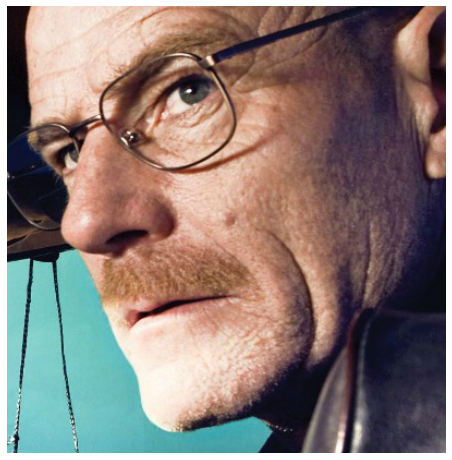

In [98]:
breaking_bad = mio.import_builtin_asset.breakingbad_jpg()
breaking_bad = breaking_bad.as_masked()
breaking_bad = breaking_bad.crop_to_landmarks(boundary=20)
breaking_bad = breaking_bad.constrain_mask_to_landmarks()
breaking_bad.view(masked=False);
print(breaking_bad.mask)

The landmarks on the breaking bad image are given as:

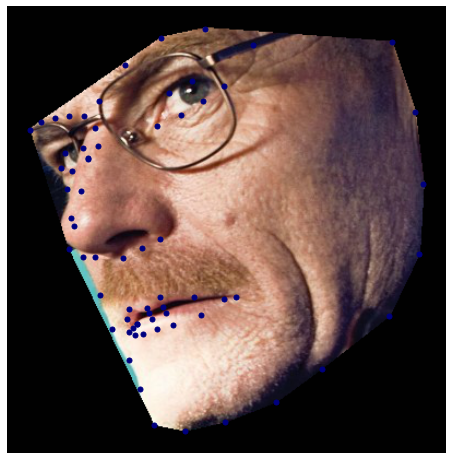

In [99]:
breaking_bad.view_landmarks();

and the Breaking Bad image has 3 channels in total (it is an RGB image).

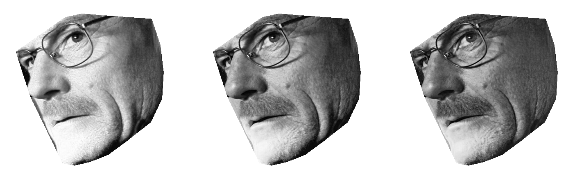

In [100]:
breaking_bad.view(channels='all');

# 1. HOG Features

The HOG (Histogram of Oriented Gradients) method clusters gradient orientations in different bins for localized sub-windows of the input image. The returned feature vector represents a binning of the orientations in to a given number of bins. 

Within Menpo, we have two different methodologies for computing HOGs, **dense** and **sparse**.

### 1.1 Dense HOGs

Dense HOGs are a formulation of HOGs that calculate a feature vector for every pixel in the image. Unlike the original formulation of HOGs (which we refer to as sparse), every single pixel is processed. This is particularly useful for parametric image alignment as it allows you to treat the resulting feature space as an image.

Below is an example of dense HOGs with sampling step of 3 pixels horizontally and vertically. In this example, we include all the possible HOG parameters.

In [101]:
from menpo.feature import hog

%time hog_img = hog(breaking_bad)

CPU times: user 4.1 s, sys: 46.7 ms, total: 4.15 s
Wall time: 4.14 s


The generated feature image can be viewed in a number of ways, to allow for simpler analysis of the effectiveness of HOGs at capturing the information in the image. The simplest way to visualise HOGs is to render each channel seperately.

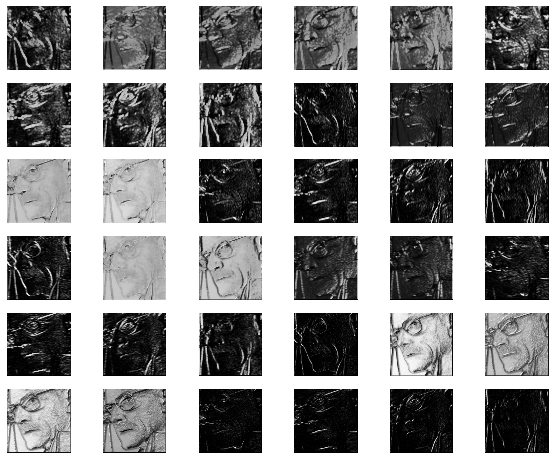

In [102]:
hog_img.view(masked=False);

We also provide a 'glyph' view, which plots the gradient vectors (in a circle) and scales their intensity by the vector magnitude. The `vectors_block_size` argument allows you to provide more pixels per circle so that the individual gradients are more easily identifiable.

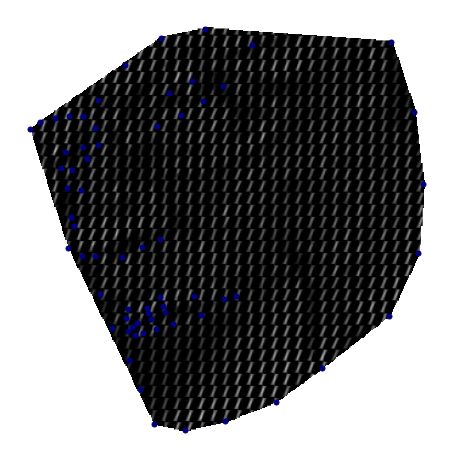

In [103]:
from menpo.feature import glyph

glyph(hog_img).view_landmarks();

However, if you use a `vectors_block_size` of 1 pixel, you will be able to see the dominant gradients for each pixel.

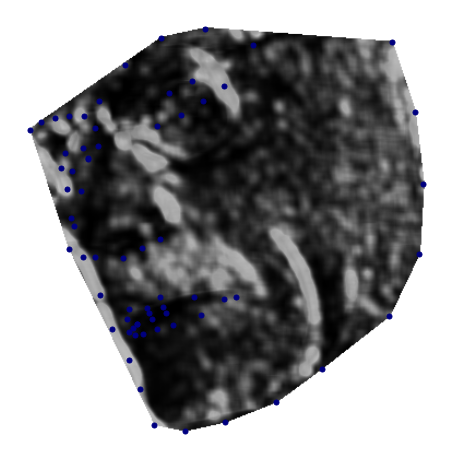

In [104]:
glyph(hog_img, vectors_block_size=1).view_landmarks();

### 1.2 Sparse HOGs

Setting `mode='sparse'` returns sparsely-sampled HOGs as defined in the original HOGs paper.

In [105]:
%timeit hog_img = hog(breaking_bad, mode='sparse', algorithm='zhuramanan')

10 loops, best of 3: 80.4 ms per loop


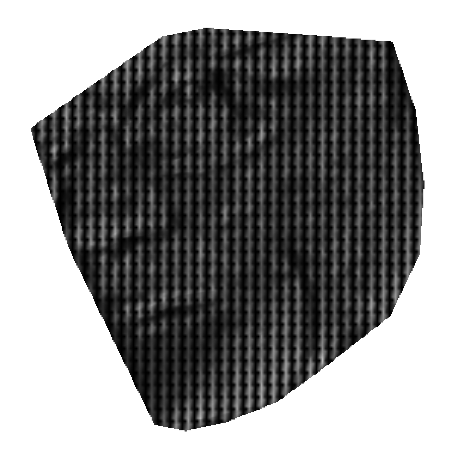

In [106]:
glyph(hog_img, vectors_block_size=4).view();

Again, we can plot all of the channels to see what information was captured

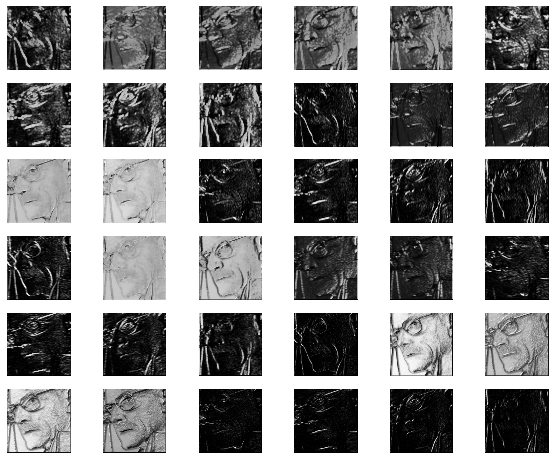

In [107]:
hog_img.view(masked=False);

### 1.3 Default Options

Let's take a look at how HOGs perform if we use our default **dense** options.

In [108]:
%time hog_img = hog(breaking_bad)

CPU times: user 4.28 s, sys: 56.7 ms, total: 4.33 s
Wall time: 4.33 s


These options return the most densely-sampled HOG version and therefore are understandbly slow!

In [109]:
print(hog_img)

403W x 411H 2D MaskedImage with 36 channels. Attached mask 58.9% true


They return a HOG image with the same width and height as the input image and 36 channels. Here we see how to render the first 9 of these channels:

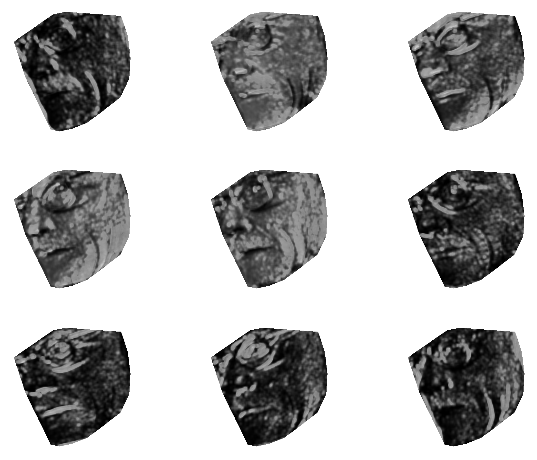

In [110]:
hog_img.view(channels=range(9));

The glyph view shows the dominant gradient directions

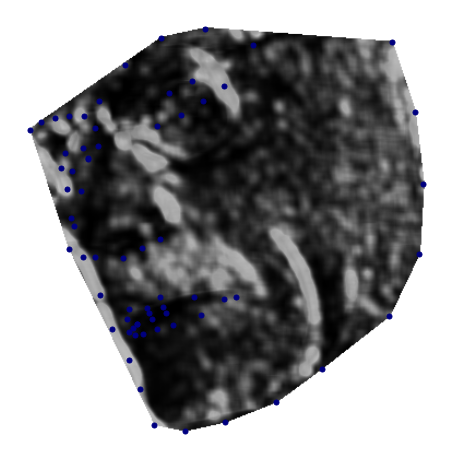

In [111]:
glyph(hog_img, vectors_block_size=1).view_landmarks();

### 1.4 Constrain Landmarks

In some cases, depending on the options given by the user, the landmarks may end up outside of the bounds of the resultant HOG image. This is easy enough to fix using the `.constrain_to_bounds()` methods on shapes to constrain the landmarks to the bounds given by the image in question. For example:

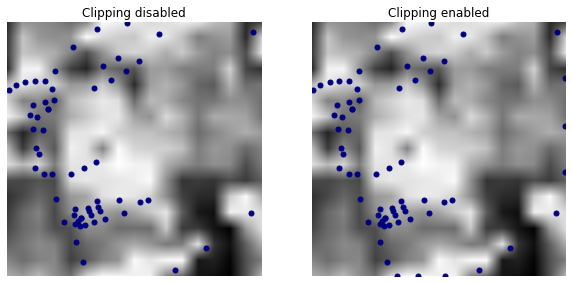

In [112]:
# clipping disabled
plt.subplot(121); plt.title('Clipping disabled')
smaller_bb = breaking_bad.resize([150, 150])
hog(smaller_bb, mode='sparse').view_landmarks(channels=1, masked=False);

# clipping enabled
plt.subplot(122); plt.title('Clipping enabled')
hog_img = hog(smaller_bb, mode='sparse')
hog_img.landmarks['PTS'] = hog_img.landmarks['PTS'].lms.constrain_to_bounds(hog_img.bounds())
hog_img.view_landmarks(channels=1, masked=False);

# 2. Dense SIFT Features

The Dense Scale-Invariant Feature Transform (SIFT) features are very similar to HOG with the difference that the orientations histograms are computed with respect to each point’s dominant orientation. We employ the VLFeat implementation of dsift. The SIFT features extraction is as simple as:

In [113]:
from menpo.feature import dsift

%time dsift_img = dsift(breaking_bad)

CPU times: user 178 ms, sys: 44.9 ms, total: 223 ms
Wall time: 222 ms


As you can see, even though they are very similar to HOG, it is actually much faster to compute them. Let' visualize all channels:

<function dsift at 0x116725ae8>


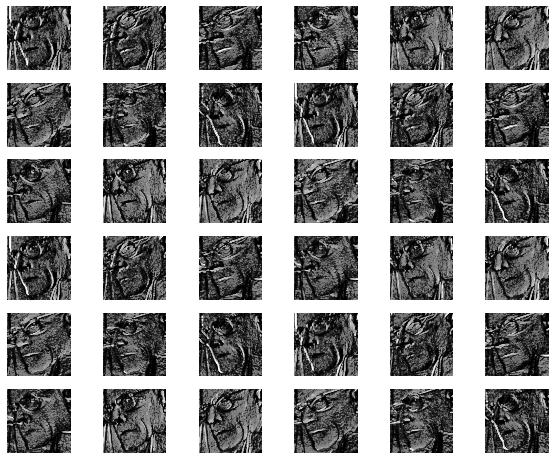

In [114]:
dsift_img.view(masked=False);
print(dsift)

and visualize the glyph:

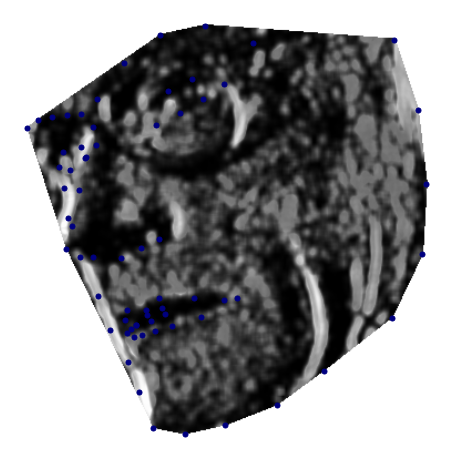

In [115]:
glyph(dsift_img, vectors_block_size=1).view_landmarks();

# 3. IGO Features

The IGO (Image Gradient Orientations) features concatenate the `cos` and `sin` of the gradient orientation angles for each image pixel. The `cos` and `sin` can be computed either on the orientation angles or on both the angle and double angle of the pixel orientations.

### 3.1 Single angles

Computing the orientation angle is as simple as:

In [116]:
from menpo.feature import igo

%time igo_img = igo(breaking_bad)

CPU times: user 48.1 ms, sys: 11.4 ms, total: 59.5 ms
Wall time: 57.9 ms


In [117]:
print(igo_img)

403W x 411H 2D MaskedImage with 6 channels. Attached mask 58.9% true


There are 6 channels total, a `sin` and a `cos` for for `RGB` channel

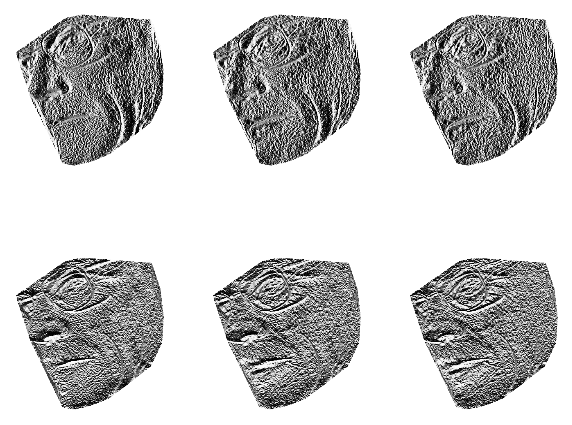

In [118]:
igo_img.view(channels='all');

You can also visualise the glyph view to give you the dominant orientations

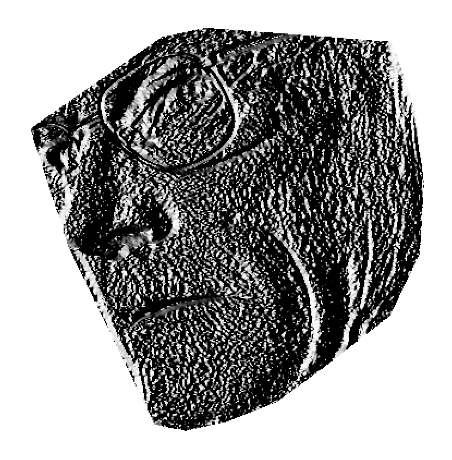

In [119]:
glyph(igo_img, vectors_block_size=2).view();

### 3.2 Double angles

IGOs only have one parameter, the `double_angles` flag. This parameter determines whether or not the double angle is also computed. The double angle is particularly useful for IGOs as it helps mitigate against the ambiguity of the sign of the angle.

In [120]:
from menpo.feature import double_igo

%time igo_img = double_igo(breaking_bad)

CPU times: user 66.1 ms, sys: 13.9 ms, total: 80 ms
Wall time: 78.5 ms


With `double_angle=True`, there are now 12 channels (the angle and double angle of each of the `RGB` channels).

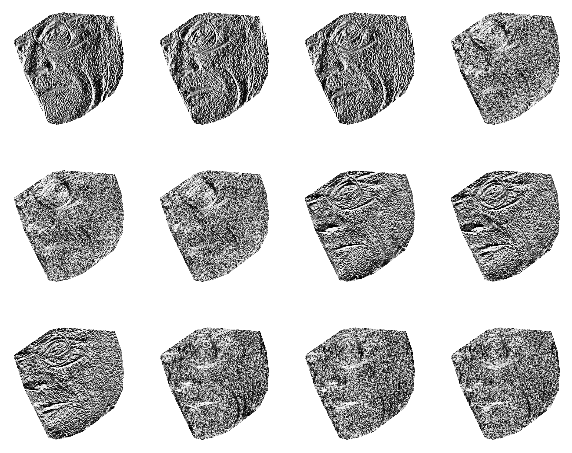

In [121]:
igo_img.view(channels='all');

The glyph view in the double angle case shows more detail, due to the increase in the number of feature channels.

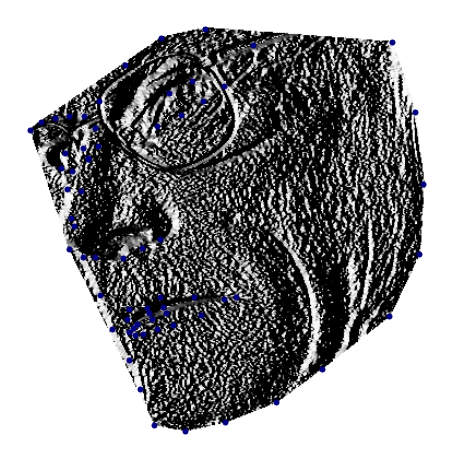

In [122]:
glyph(igo_img, vectors_block_size=1).view_landmarks();

# 4. ES Features

The ES (Edge Structure) feature provides a measure which captures the orientation of image edge structure at each pixel, together with an indication of how accurate the orientation estimate is. The accuracy belief measure penalizes the orientations in flat, noisy regions and favours the ones near strong edges. Here is an example:

In [123]:
from menpo.feature import es

%time es_img = es(breaking_bad)

CPU times: user 20.4 ms, sys: 8.7 ms, total: 29.1 ms
Wall time: 27.3 ms


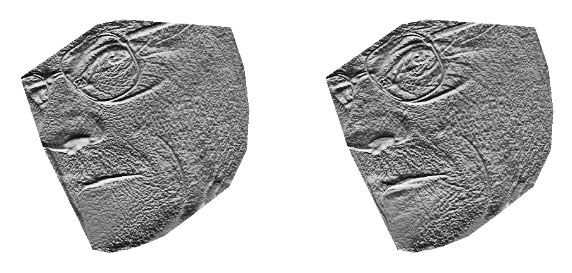

In [124]:
es_img.view(channels=[0, 1]);

The glyph view gives an indication of the dominant gradient direction.

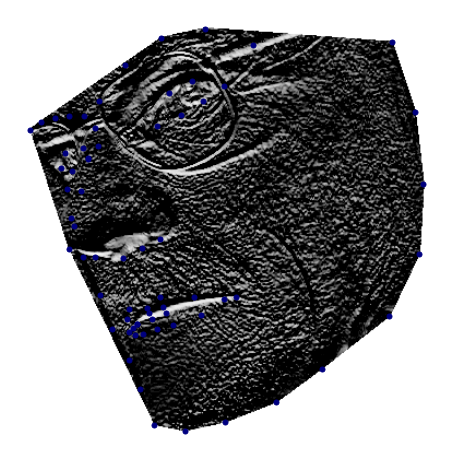

In [125]:
glyph(es_img, vectors_block_size=1).view_landmarks();

# 5. LBP Features

The basic idea behind the LBP (Local Binary Patterns) feature is to encode the local structure in an image by comparing each pixels intensity value with its neighbors and then assign an appropriate code. The user can control the density through the `window_step_vertical` and `window_step_horizontal` parameters. At each pixel, the LBP code is computed on circle(s) with radius (radii) defined in `radius`. For each `radius` value, the user has to define the respective number of sampling points, using the parameter `samples`. The parameter `mapping_type` defines the LBP codes mapping: `uniform-2`, `rotation-invariant` or `uniform-2 and rotation_invariant`.

In this example, we extract dense LBP features using two `radius/samples` combinations. The example also illustrates all the possible parameters to the LBP function.

In [126]:
from menpo.feature import lbp

In [127]:
%%time 

lbp_img = lbp(breaking_bad,
              radius=[3, 4],
              samples=[10, 12],
              mapping_type='ri',
              window_step_vertical=1,
              window_step_horizontal=1,
              window_step_unit='pixels',
              padding=True)

CPU times: user 337 ms, sys: 9.37 ms, total: 346 ms
Wall time: 345 ms


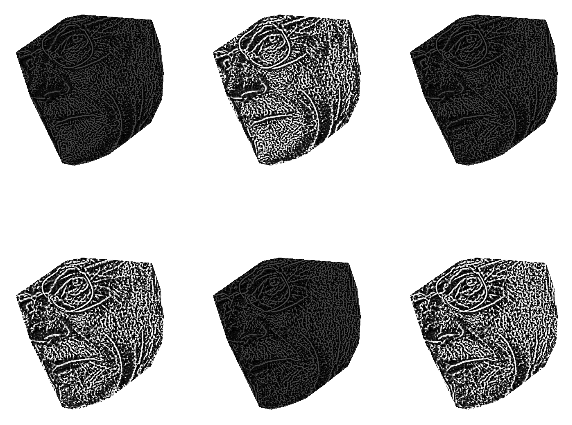

In [128]:
lbp_img.view(channels='all');

The default values for LBPs yield the following results:

In [129]:
%time lbp_img = lbp(breaking_bad)

CPU times: user 416 ms, sys: 15.2 ms, total: 431 ms
Wall time: 430 ms


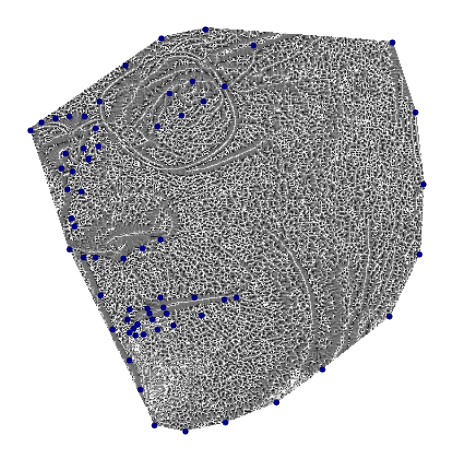

In [130]:
glyph(lbp_img, vectors_block_size=1).view_landmarks();

### 5.1 LBP Codes Histogram

LBPs are ideal to be used as image descriptors. This is achieved by binning the codes of the output image, as follows:

In [131]:
grey_bb = breaking_bad.as_greyscale()
hist, bin_edges = lbp(grey_bb, radius=1, samples=8).as_histogram()

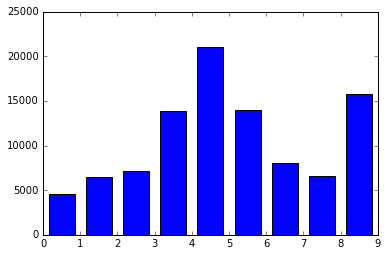

In [132]:
%matplotlib inline
width = 0.7 * (bin_edges[1] - bin_edges[0])
center = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.bar(center, hist, align='center', width=width);

# 6. Daisy

The Daisy descriptor is based on gradient orientation histograms. It is formulated in a way that allows for fast dense extraction which is useful for e.g. bag-of-features image representations. Note that we use the implementation of _scikit-image_.

In [133]:
from menpo.feature import daisy

In [134]:
%%time 

daisy_img = daisy(breaking_bad, normalization='daisy')

CPU times: user 350 ms, sys: 38.8 ms, total: 389 ms
Wall time: 331 ms


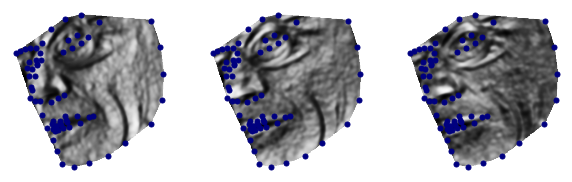

In [135]:
daisy_img.view_landmarks(channels=range(3));

Daisy features have several options, such as `step`

Daisy Features:
  - Input image is 403W x 411H with 3 channels.
  - Sampling step is 2.
  - Radius of 15 pixels, 2 rings and 2 histograms with 8 orientations.
  - Using l1 normalization.
Output image size 187W x 191H x 40.


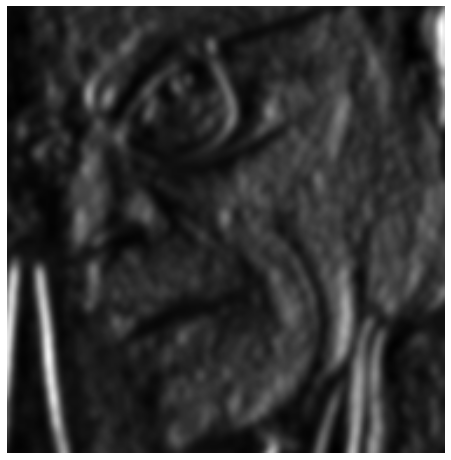

In [136]:
daisy(breaking_bad, step=2, verbose=True).view(channels=0, masked=False);

# 7. Others

The `feature` package has also `gradient`. For example

In [137]:
from menpo.feature import gradient

In [138]:
%%time
gradient_img = gradient(breaking_bad);

CPU times: user 4.16 ms, sys: 552 µs, total: 4.71 ms
Wall time: 3.86 ms


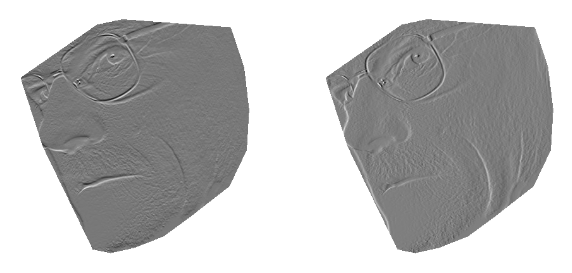

In [139]:
gradient_img.view(channels=[0, 3]);

Moreover, there is the `no_op()` function that stands for _no operation_. This means that the input image will be returned untouched.

# 8. Features Combination

Features can be used consecutively. This means that a user is able to extract features from a features image (though this might not make much sense for some combinations of features!). For example we can compute the LBP features of the IGO-based image

In [140]:
igo_image = igo(grey_bb, verbose=True)
lbp_igo = lbp(igo_image, radius=2, samples=8, mapping_type='none', verbose=True)

IGO Features:
  - Input image is 403W x 411H with 1 channels.
  - Double angles are disabled.
Output image size 403W x 411H with 1 channels.
Window Iterator:
  - Input image is 403W x 411H with 2 channels.
  - Window of size 5W x 5H and step (1W,1H).
  - Padding is enabled.
  - Number of windows is 403W x 411H.
LBP features:
  - 1 combination of radius and samples.
  - Radius value: 2.
  - Samples value: 8.
  - No codes mapping used.
  - Descriptor length per window = 2 x 1.
Output image size 403W x 411H x 2.


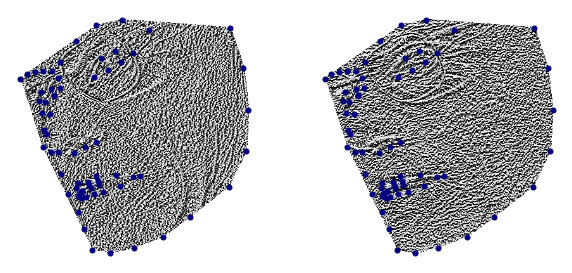

In [141]:
lbp_igo.view_landmarks(channels='all');

# 9. Widgets

The feature package has a feature selection widget called `features_selection_widget()`. Note that the widget functionality is provided by the menpowidgets project and should be installed separately using conda (`conda install -c menpo menpowidgets`). This allows the user to select a specific features function and each options. The widget has a preview tab that employs the Lenna image and returns a a list with a function closure.

In [142]:
from menpowidgets import features_selection

selected_feat = features_selection()

So the selected feature can be applied to the breaking bad image as

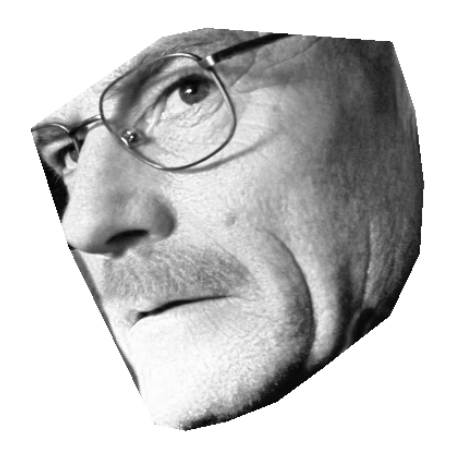

In [143]:
selected_feat[0](breaking_bad).view(channels=0);

Finally, as mentioned in the Image Basics notebook, a list of images can also be viewed using the `visualize_images()` widget.

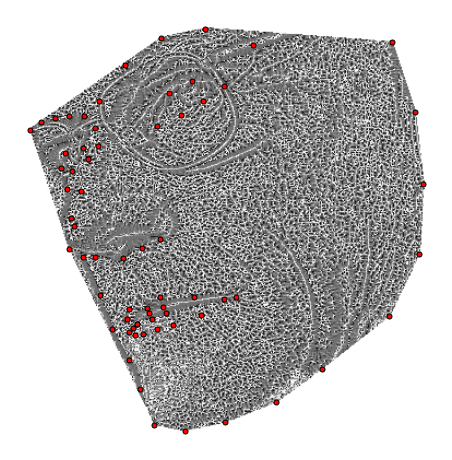

In [144]:
from menpowidgets import visualize_images

visualize_images([breaking_bad, igo_img, es_img, lbp_img, daisy_img, hog_img, gradient_img])